In [23]:
import deepxde as dde
import numpy as np
import torch
dde.config.set_default_float("float64")

Set the default float type to float64


In [24]:
##Parameters Setup
D_A = 6  #6nm^2/s
kf_11 = 0
kf_21 = 0
kf_12 = 0

h = 150  ##metal film thickness 1nm = 1e-7cm
L = 800  ##SiCsub strate thickness(the solutionregion depth)

time_length = 0.1   #minutes  

$\frac\partial{\partial x}\left(D^*\frac{\partial C_？}{\partial x}\right)=D^*\frac{\partial^2C_？}{\partial x^2}+\left(D_\mathrm{A}\frac{C_\mathrm{A}\left(\frac{\partial C_\mathrm{BC}}{\partial x}+\frac{\partial C_\mathrm{C}}{\partial x}+\frac{\partial C_\mathrm{AB}}{\partial x}+\frac{\partial C_\mathrm{ABB}}{\partial x}+\frac{\partial C_\mathrm{AAB}}{\partial x}\right)-\left(C_\mathrm{BC}+C_\mathrm{C}+C_\mathrm{AB}+C_\mathrm{ABB}+C_\mathrm{AAB}\right)\frac{\partial C_\mathrm{A}}{\partial x}}{C_\mathrm{\Sigma}^2}\right)\frac{\partial C_？}{\partial x}$

In [25]:
def pde(x,y): ##第一个x输入的是一个二维向量，第一个指的是x(j=0),第二个指的是t(j=1)。
    # 提取y中的各个分量
    components = [y[:, i:i+1] for i in range(6)]
    c_a, c_bc, c_c, c_ab, c_abb, c_aab = components

    # 公共变量 common variables
    C_sigma_big = c_a + c_bc + c_c + c_ab +c_abb + c_aab
    C_sigma_small = c_bc + c_c + c_ab +c_abb + c_aab
    D_star = D_A * (C_sigma_small/C_sigma_big)   #This time we don't have D_C

    #微分项
    dca_dx = dde.grad.jacobian(y, x, i=0, j=0)  ##Compute Jacobian matrix J as J[i, j] = dy_i / dx_j
    dcbc_dx = dde.grad.jacobian(y, x, i=1, j=0)
    dcc_dx = dde.grad.jacobian(y, x, i=2, j=0)
    dcab_dx = dde.grad.jacobian(y, x, i=3, j=0)
    dcabb_dx = dde.grad.jacobian(y, x, i=4, j=0)
    dcaab_dx = dde.grad.jacobian(y, x, i=5, j=0)

    dsigma_dx = dcbc_dx + dcc_dx + dcab_dx + dcabb_dx + dcaab_dx

    ##eq1:
    dca_dt = dde.grad.jacobian(y, x, i=0, j=1)  #t为x的 2-coordinate j=1
    dca_dxx = dde.grad.hessian(y, x, component=0, i=0, j=0) 
            #Compute Hessian matrix H as H[i, j] = d^2y / dx_i dx_j, where i,j = 0, …, dim_x - 1
            #Use component to select y_i = 0
    eq_1 = dca_dt - D_star * dca_dxx - dca_dx * \
        (D_A * (c_a * dsigma_dx - dca_dx * C_sigma_small)/ (C_sigma_big ** 2)) + 0 # \
        #kf_11 * c_a * c_bc + kf_21 * c_a * c_ab 
    
    ##eq2:
    dcbc_dt = dde.grad.jacobian(y,x,i=1,j=1)  #t为x的 2-coordinate j=1
    dcbc_dxx = dde.grad.hessian(y,x,component=1,i=0,j=0)  ##cbc为y的 2-coordinate component =1
    eq_2 = dcbc_dt - D_star * dcbc_dxx - dcbc_dx * \
        (D_A * (c_a * dsigma_dx - dca_dx * C_sigma_small)/ (C_sigma_big ** 2)) + 0 #\
        #kf_11 * c_a * c_bc + kf_12 * c_ab * c_bc 

    ##eq3
    dcc_dt = dde.grad.jacobian(y,x,i=2,j=1)  #t为x的 2-coordinate j=1
    dcc_dxx = dde.grad.hessian(y,x,component=2,i=0,j=0) ##cc为y的 3-coordinate component =2
    eq_3 = dcc_dt - D_star * dcc_dxx - dcc_dx * \
        (D_A * (c_a * dsigma_dx - dca_dx * C_sigma_small)/ (C_sigma_big ** 2)) - 0# \
        #kf_11 * c_a * c_bc - kf_12 * c_ab * c_bc 
    
    ##eq4
    dcab_dt = dde.grad.jacobian(y,x,i=3,j=1)
    eq_4 = dcab_dt - kf_11 * c_a * c_bc + kf_21 * c_a * c_ab 

    ##eq5
    dcabb_dt = dde.grad.jacobian(y,x,i=4,j=1)
    eq_5 = dcabb_dt - kf_12 * c_bc * c_ab
    ##eq6
    dcaab_dt = dde.grad.jacobian(y,x,i=5,j=1)
    eq_6 = dcaab_dt - kf_21 * c_a * c_ab 

    return [eq_1,eq_2,eq_3,eq_4,eq_5,eq_6]
    # return [eq_1,eq_2,eq_3]


In [26]:
# 假设L和time_length已经在上下文中定义并赋值
try:
    geom = dde.geometry.Interval(0, L)
    timedomain = dde.geometry.TimeDomain(0, time_length)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
except Exception as e:
    print(f"An error occurred: {e}")
    # 可以在这里添加更多的异常处理逻辑，例如记录错误日志、回滚操作等

In [27]:
# 定义初始条件函数
N_SA = 90  
N_SB = 48  #nm^{-3}

# 定义Neumann边界条件 Neumann-BC
bc_neumann_C_A = dde.icbc.NeumannBC(geomtime, lambda x:0, lambda _, on_boundary:on_boundary,component=0)
bc_neumann_C_BC = dde.icbc.NeumannBC(geomtime, lambda x:0, lambda _, on_boundary:on_boundary,component=1)
bc_neumann_C_C = dde.icbc.NeumannBC(geomtime, lambda x:0, lambda _, on_boundary:on_boundary,component=2)

boundary_conditions = [bc_neumann_C_A, bc_neumann_C_BC, bc_neumann_C_C]

def initial_condition_Ca(x):
    # 创建一个掩码，标识 x 的第一列中哪些元素在区间 [0, h] 内
    mask = (x[:, 0] >= 0) & (x[:, 0] <= h)  
    result = np.zeros_like(x[:, 0:1])
    result[mask] = N_SA
    return result

def initial_condition_Cb(x):
       # 创建一个掩码，标识 x 的第一列中哪些元素在区间 [0, h] 内
    mask = (x[:, 0] >= h) & (x[:, 0] <= L)
    result = np.zeros_like(x[:, 0:1])
    x[mask] = N_SB
    return result

def initial_condition_zeros(x):
    return np.zeros_like(x[:, 0:1])

# 定义初始条件
ic_C_A = dde.icbc.IC(geomtime, initial_condition_Ca,lambda _, on_initial: on_initial, component=0)
ic_C_BC = dde.icbc.IC(geomtime,initial_condition_Cb, lambda _, on_initial: on_initial, component=1)
ic_C_C = dde.icbc.IC(geomtime, initial_condition_zeros, lambda _, on_initial: on_initial, component=2)
ic_C_AB = dde.icbc.IC(geomtime, initial_condition_zeros, lambda _, on_initial: on_initial, component=3)
ic_C_ABB = dde.icbc.IC(geomtime, initial_condition_zeros, lambda _, on_initial: on_initial, component=4)
ic_C_AAB = dde.icbc.IC(geomtime, initial_condition_zeros, lambda _, on_initial: on_initial, component=5)

# initial_conditions = [ic_C_A, ic_C_BC, ic_C_C]
initial_conditions = [ic_C_A, ic_C_BC, ic_C_C, ic_C_AB, ic_C_ABB, ic_C_AAB]


In [28]:
data = dde.data.TimePDE(
    geomtime, 
    pde, 
    initial_conditions + boundary_conditions,
    num_domain=3000, 
    num_boundary=300,
    num_initial=300, 
    # num_test= 30000##we don't have solution = ? as a reference.
)

Compiling model...
'compile' took 0.004815 s

Training model...

Step      Train loss                                                                                                                                                Test loss                                                                                                                                                 Test metric
0         [4.86e+05, 7.91e+04, 2.49e+06, 1.29e-04, 1.63e-02, 5.69e-04, 1.54e+03, 3.83e-02, 4.51e-01, 5.22e-01, 2.99e-02, 1.01e+00, 1.96e-02, 3.20e-03, 1.00e-01]    [4.86e+05, 7.91e+04, 2.49e+06, 1.29e-04, 1.63e-02, 5.69e-04, 1.54e+03, 1.30e-02, 4.51e-01, 5.22e-01, 2.99e-02, 1.01e+00, 1.96e-02, 3.20e-03, 1.00e-01]    []  
1000      [3.81e-04, 1.54e-03, 2.53e-02, 2.75e-03, 3.81e-02, 2.41e-03, 1.54e+03, 2.70e-02, 4.36e-01, 4.37e-01, 2.00e-03, 1.10e+00, 1.21e-02, 1.30e-03, 7.52e-02]    [3.81e-04, 1.54e-03, 2.53e-02, 2.75e-03, 3.81e-02, 2.41e-03, 1.54e+03, 2.70e-02, 4.36e-01, 4.37e-01, 2.00e-03, 1.10e+0

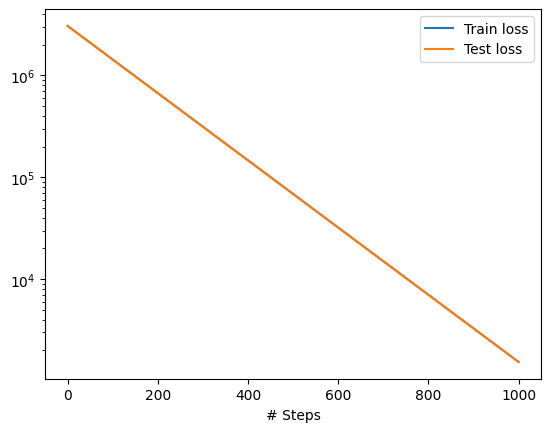

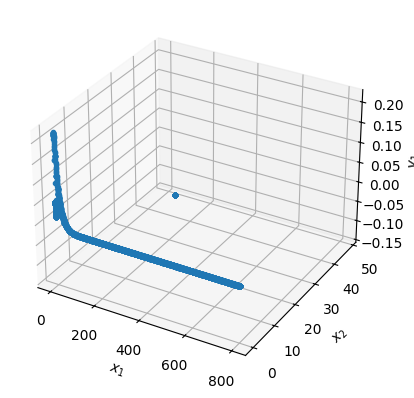

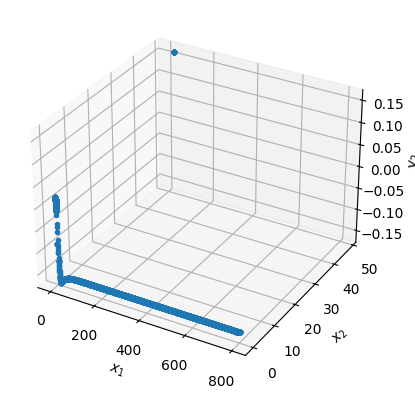

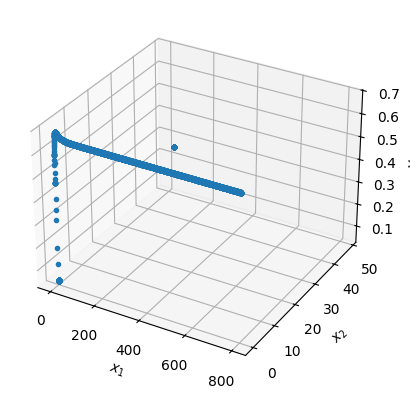

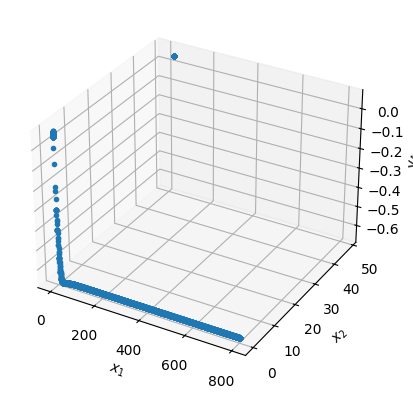

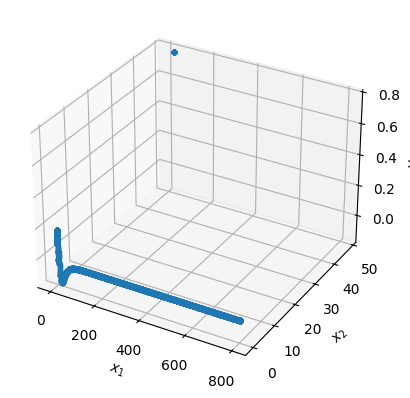

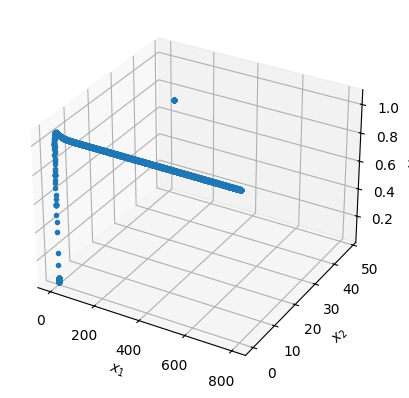

In [29]:
# 定义神经网络模型
net = dde.nn.FNN([2] + [20] * 3 + [6], "tanh", "Glorot normal")  
# Two inputs : x ,t
# Six outputs: c_a, c_bc, c_c, c_ab, c_abb, c_aab

# 定义模型
model = dde.Model(data, net)

# 编译模型
model.compile("adam", lr=1e-3)

# 训练模型
losshistory, train_state = model.train(iterations=1000)

# 可视化结果
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

(256,)


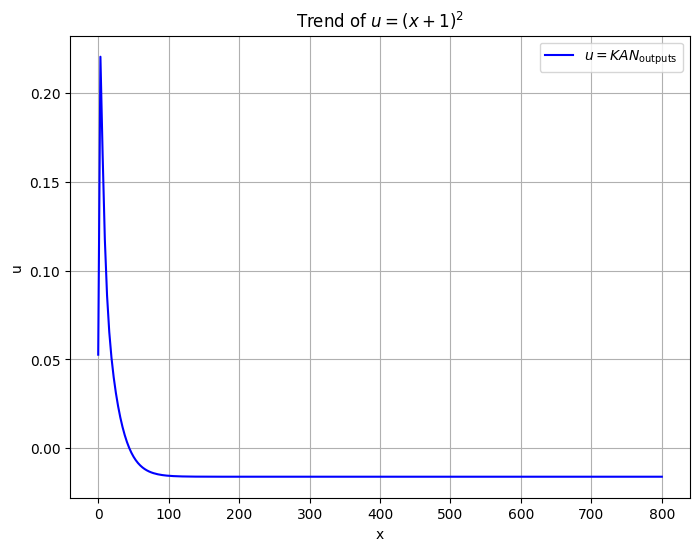

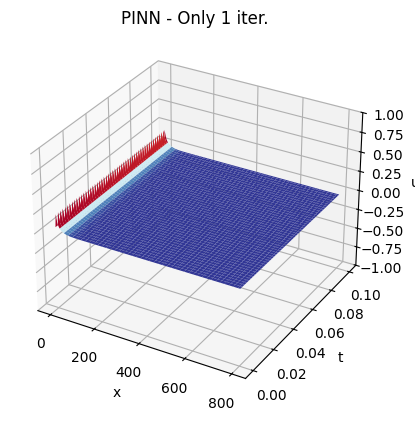

In [30]:
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import matplotlib.pyplot as plt

x = np.linspace(0, L, 256)
t = np.linspace(0, time_length, 100)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star, operator=None)

c_a = prediction[:,0].reshape(100,256)
print(c_a[1].shape)

plt.figure(figsize=(8, 6))
plt.plot(x, c_a[1], label=r'$u = KAN_{\text{outputs}}$', color='b')
plt.title('Trend of $u = (x + 1)^2$')
plt.xlabel('x')
plt.ylabel('u')
# plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.show()



fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([-1, 1])
ax.plot_surface(X, T, c_a, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('PINN - Only 1 iter.') 
plt.show(fig)
